# Purpose
An attempt to reproduce the results of https://iopscience.iop.org/article/10.1088/2632-2153/ab80b7#mlstab80b7s5 on alanine dipeptide to check on FVE dependence on various hyperparameters and assess whether the reconstruction is semi-decent on a protein system. (Later step would be to compare with alanine-glycine or glycine dipeptide).

FES (approximate) of glycine dipeptide can be found here "Comparison of a QM/MM force field and molecular mechanics force fields in simulations of alanine and glycine "dipeptides" (Ace-Ala-Nme and Ace-Gly-Nme) in water in relation to the problem of modeling the unfolded peptide backbone in solution"

# Imports

In [2]:
import sys
import tensorflow as tf
import numpy as np
import itertools
import os
import time
import mdshare

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import pyemma
import mdtraj
import nglview as nv #conda install nglview -c conda-forge

from scipy.stats import kurtosis
from sklearn.preprocessing import StandardScaler

sys.path.append('gmvae')
from model import GMVAE
from dataset import load_and_mix_data_nolabel

matplotlib.rcParams.update({'font.size': 24})

# Paths

In [3]:
readdir = 'data/'
savedir = 'results/'
modeldir = 'models/'

# Data Analysis
## Load Trajectories with PyEmma and create representation

In [4]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

Since in general the optimal set of input features is unknown a priori, we use this example to test the ability of
the GMVAE to identify the proper collective variables from a larger set of input features. More specifically, we
consider as input features both the normalized pairwise distances between heavy atoms as well as the (φ, ψ)
dihedral angles (obtained from [53]). The pairwise distances were pre-processed using a kurtosis filter (with
the threshold value of 0.03, see figure S4 for more detail), to reduce the input dimension by removing the
low-variance features. The dihedral angles were pre-processed by applying sin and cos transformations in
order to account for periodicity [54].

In [11]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
feat.add_distances(feat.select_Heavy(),periodic=False)
data = pyemma.coordinates.load(files, features=feat)

03-03-22 10:42:57 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[2] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


Check the output of describe() to see the actual order of the features


Obtaining file info:   0%|                                                                        | 0/3 [00:00…

getting output of FeatureReader:   0%|                                                            | 0/3 [00:00…

In [25]:
len(feat.describe())

47

In [12]:
feat.describe()

['PHI 0 ALA 2',
 'PSI 0 ALA 2',
 'DIST: ACE 1 CH3 1 - ACE 1 C 4',
 'DIST: ACE 1 CH3 1 - ACE 1 O 5',
 'DIST: ACE 1 CH3 1 - ALA 2 N 6',
 'DIST: ACE 1 CH3 1 - ALA 2 CA 8',
 'DIST: ACE 1 CH3 1 - ALA 2 CB 10',
 'DIST: ACE 1 CH3 1 - ALA 2 C 14',
 'DIST: ACE 1 CH3 1 - ALA 2 O 15',
 'DIST: ACE 1 CH3 1 - NME 3 N 16',
 'DIST: ACE 1 CH3 1 - NME 3 C 18',
 'DIST: ACE 1 C 4 - ACE 1 O 5',
 'DIST: ACE 1 C 4 - ALA 2 N 6',
 'DIST: ACE 1 C 4 - ALA 2 CA 8',
 'DIST: ACE 1 C 4 - ALA 2 CB 10',
 'DIST: ACE 1 C 4 - ALA 2 C 14',
 'DIST: ACE 1 C 4 - ALA 2 O 15',
 'DIST: ACE 1 C 4 - NME 3 N 16',
 'DIST: ACE 1 C 4 - NME 3 C 18',
 'DIST: ACE 1 O 5 - ALA 2 N 6',
 'DIST: ACE 1 O 5 - ALA 2 CA 8',
 'DIST: ACE 1 O 5 - ALA 2 CB 10',
 'DIST: ACE 1 O 5 - ALA 2 C 14',
 'DIST: ACE 1 O 5 - ALA 2 O 15',
 'DIST: ACE 1 O 5 - NME 3 N 16',
 'DIST: ACE 1 O 5 - NME 3 C 18',
 'DIST: ALA 2 N 6 - ALA 2 CA 8',
 'DIST: ALA 2 N 6 - ALA 2 CB 10',
 'DIST: ALA 2 N 6 - ALA 2 C 14',
 'DIST: ALA 2 N 6 - ALA 2 O 15',
 'DIST: ALA 2 N 6 - NME 3 N 

In [21]:
alldata = np.concatenate((data[0],data[1],data[2]))

In [22]:
alldata.shape

(750000, 47)

In [23]:
alldata[:,2:] = StandardScaler().fit_transform(alldata[:,2:])

In [24]:
alldata.shape

(750000, 47)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Feature values', ylabel='Feature histograms'>)

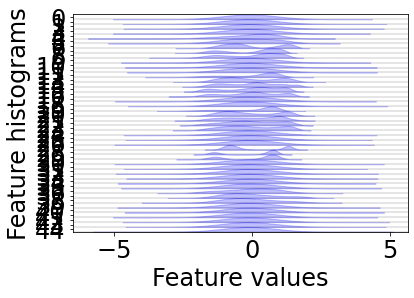

In [27]:
pyemma.plots.plot_feature_histograms(alldata[:,2:])

In [33]:
k = kurtosis(alldata[:,2:],axis=0)

In [35]:
kthresh = 0.03
k[np.abs(k)<kthresh]=0

In [36]:
kmask = [0,1]+list(np.where(k)[0]+2)

In [37]:
threshdata = alldata[:,kmask]

In [38]:
threshdata.shape

(750000, 23)

They started with an input dimension of 25; we start with 23, probably due to slight differences in the employed trajectories.  Still probably okay, let's take a look.  Oh no, wait, we will have 25, we still have to transform the dihedrals to sin & cos.

In [39]:
newdata = np.zeros((threshdata.shape[0],threshdata.shape[1]+2))
newdata[:,0] = np.cos(threshdata[:,0])
newdata[:,1] = np.sin(threshdata[:,0])
newdata[:,2] = np.cos(threshdata[:,1])
newdata[:,3] = np.sin(threshdata[:,1])
newdata[:,4:] = threshdata[:,2:]

Here is what we're comparing with: 
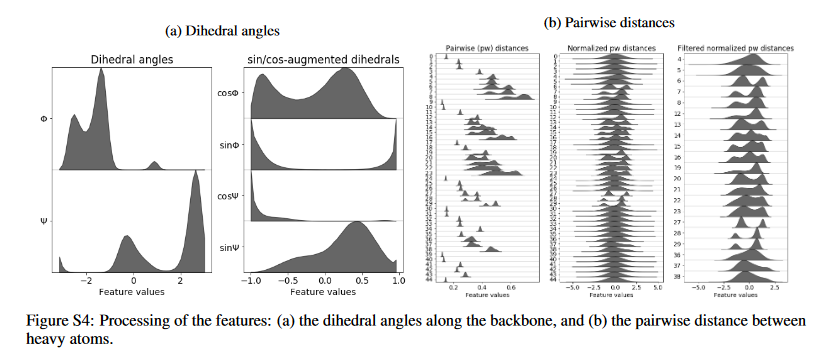

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Feature values'>)

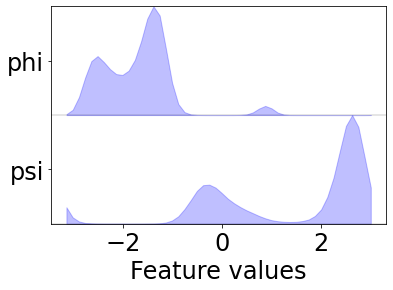

In [40]:
pyemma.plots.plot_feature_histograms(threshdata[:,:2],feature_labels=['phi','psi'])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Feature values'>)

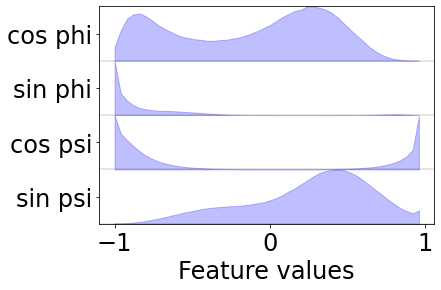

In [41]:
pyemma.plots.plot_feature_histograms(newdata[:,:4],feature_labels=['cos phi','sin phi','cos psi','sin psi'])

(<Figure size 576x720 with 1 Axes>,
 <AxesSubplot:xlabel='Feature values', ylabel='Feature histograms'>)

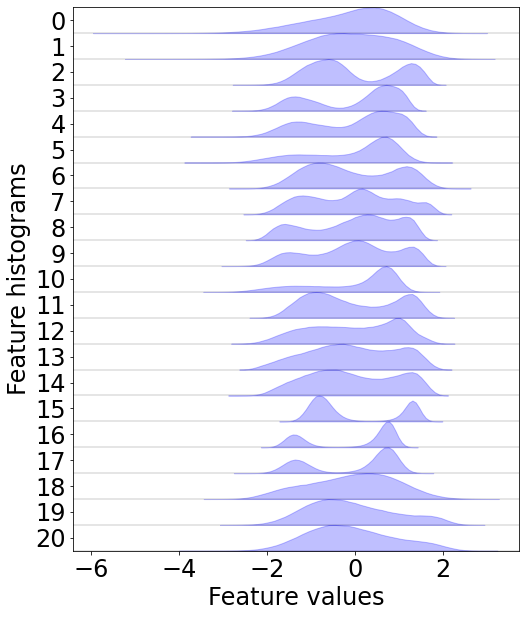

In [48]:
fig,ax = plt.subplots(figsize=(8,10))
pyemma.plots.plot_feature_histograms(newdata[:,4:],ax=ax)

Okay this all looks good.  Now for the next few steps.  Check the training hyperparameters from the paper.
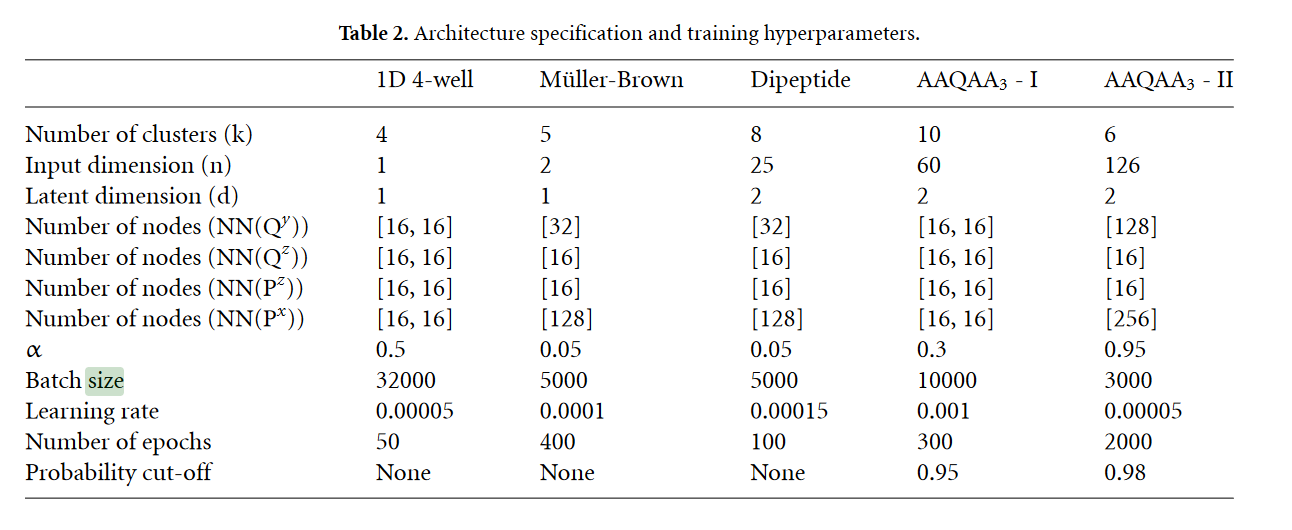

graph written


2022-03-03 11:04:42.911223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:04:42.911274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch                                              
  1.92e+00,  3.64e+01,  1.81e+00,  3.35e+01,         1
Sample of qy
0.22 0.07 0.07 0.07 0.18 0.16 0.07 0.18 
0.13 0.09 0.09 0.09 0.12 0.13 0.11 0.25 
0.08 0.11 0.08 0.09 0.13 0.08 0.19 0.25 
0.08 0.10 0.08 0.08 0.11 0.08 0.18 0.29 
0.12 0.12 0.12 0.12 0.12 0.12 0.15 0.14 

epoch:         50                                                                                   
    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch                                              
  4.90e-02,  1.83e+00,  4.83e-02,  1.82e+00,        51
Sample of qy
0.00 0.00 0.87 0.00 0.13 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 

epoch:        100                                                                                   


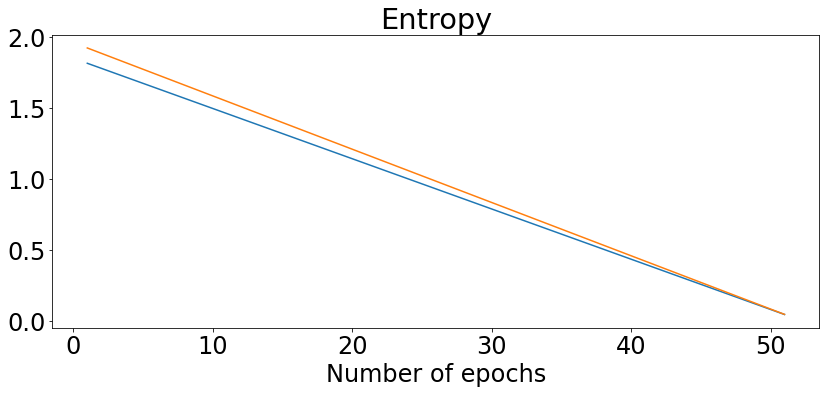

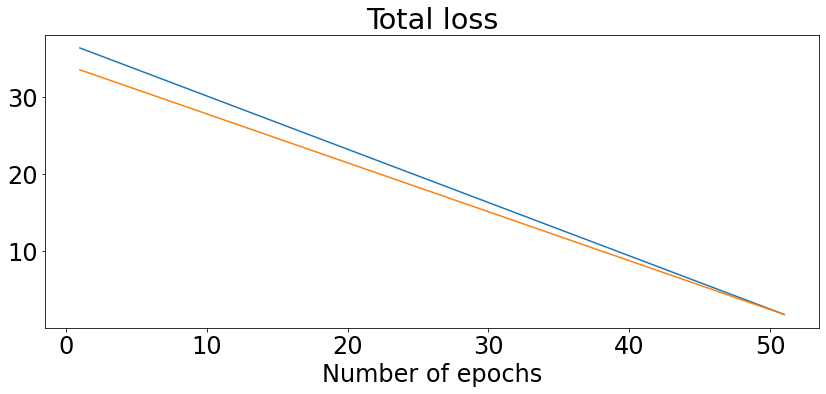

In [51]:
k, n_x, n_z, n_epochs = 8, 25, 2, 100
qy_dims = [32]
qz_dims = [16]
pz_dims = [16]
px_dims = [128]
r_nent = 0.05
batch_size = 5000
lr = 0.00015
modelname='dipeptide_'
dataset = load_and_mix_data_nolabel(data=newdata, test_ratio=0.01,randomize=True)
def train_gmvae(k,n_x,n_z,n_epochs,
               qy_dims,qz_dims,pz_dims,px_dims,
               r_nent,batch_size,lr,dataset,modelname):
    

    model_path = modeldir + modelname +str(k)+'_'+str(n_z)+'_'+str(n_epochs)+'_'+str(r_nent)+'_' + str(batch_size)
    results = '_results'

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    results_dir_s = model_path+results

    if not os.path.exists(results_dir_s):
        os.makedirs(results_dir_s)

    results_dir = Path(results_dir_s)

    model = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
                  qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
                  r_nent = r_nent, batch_size=batch_size, lr=lr)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        history, ye, ze = model.train(dataset, sess, epochs=n_epochs,
                                      n_train_eval=200000, n_test_eval=200000, save_parameters=True, 
                                      is_labeled=False, track_losses=True, verbose=True)

    f = open(model_path + '/training_params.txt','w+')
    f.write(f'k={k}, n_x={n_x}, n_z={n_z}, n_epochs={n_epochs}, qy_dims={qy_dims}, qz_dims={qz_dims}, '+
            f'pz_dims={pz_dims}, px_dims={px_dims}, r_ent={r_nent}, batch_size={batch_size}, lr={lr}')
    raw_data = {'k': [k], 'n_x': [n_x], 'n_z': [n_z], 'n_epochs': [n_epochs], 'qy_dims': [qy_dims], 'qz_dims': [qz_dims], 'pz_dims': [pz_dims], 
                'px_dims': [px_dims], 'r_nent': [r_nent], 'batch_size': [batch_size], 'lr': [lr]}
    df = pd.DataFrame(data=raw_data)
    df.to_pickle(model_path + '/training_params.pkl')
    f.close()
    fig, axes = plt.subplots(figsize = (12,6), nrows=1, ncols=1)
    axes.plot(history['iters'], history['val_ent'])
    axes.plot(history['iters'], history['ent'])
    axes.set_title('Entropy')
    axes.set_xlabel('Number of epochs')
    plt.tight_layout() 
    plt.savefig(str(results_dir) + 'training_ent.png')
    plt.show()
    
    fig, axes = plt.subplots(figsize = (12,6), nrows=1, ncols=1)
    axes.plot(history['iters'], history['loss'])
    axes.plot(history['iters'], history['val_loss'])
    axes.set_title('Total loss')
    axes.set_xlabel('Number of epochs')
    plt.tight_layout() 
    plt.savefig(str(results_dir) + 'training.png')
    plt.show()
    return model
model = train_gmvae(k,n_x,n_z,n_epochs,
               qy_dims,qz_dims,pz_dims,px_dims,
               r_nent,batch_size,lr,dataset,modelname)

In [52]:
def frac_var_explained(inputX,outputX):
    meanX = inputX.mean(axis=0)
    sse = 0
    sst = 0
    for q in range(inputX.shape[0]):
        sse += np.dot(inputX[q,:]-outputX[q,:],
                     inputX[q,:]-outputX[q,:])
        sst += np.dot(inputX[q,:]-meanX,
                     inputX[q,:]-meanX)
    fve = 1 - sse/sst
    return fve

def basic_model_assess(model,traindata):
    qy = model.encode_y(traindata)
    y_pred = np.argmax(qy, axis=1)
    z = model.encode_z(traindata)
    outX = model.reconstruct(traindata)
    fve = frac_var_explained(traindata,outX)
    print("{0} clusters found out of {1} allowed".format(len(np.unique(y_pred)),model.k))
    print("FVE of model: {}".format(fve))
    return z,y_pred,fve

In [58]:
z,y_pred,fve=basic_model_assess(model,newdata)

INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:44:11.155860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:44:11.155916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:44:12.214878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:44:12.214928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:44:14.742496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:44:14.742556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:44:15.206583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:44:15.206639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:44:18.409073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:44:18.409366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


7 clusters found out of 8 allowed
FVE of model: 0.8963159611254755


In [54]:
def illustrate_and_reconstruct(model,data,results_dir):
    z = model.encode_z(data)
    matplotlib.rcParams.update({'font.size': 28})
    plt.figure(figsize=(8,6))
    _ = plt.hist(z[:,0], bins= np.arange(-5, 5, 0.075), density=True)
    ah = np.histogram(z[:,0], bins= np.arange(-5, 5, 0.075), density=True)
    plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
    plt.ylabel('Density', labelpad=20)
    plt.xlabel('z1', labelpad=20)
    plt.xticks(np.arange(-5, 5))
    plt.xlim([-5,5])
    plt.ylim([0, 1])
    titlename = 'z1_histograms_line'
    plt.tight_layout()
    plt.savefig(str(results_dir) + '/z1_histogram.png', bbox_inches='tight')
    
    matplotlib.rcParams.update({'font.size': 28})
    plt.figure(figsize=(8,6))
    _ = plt.hist(z[:,1], bins= np.arange(-5, 5, 0.075), density=True)
    ah = np.histogram(z[:,1], bins= np.arange(-5, 5, 0.075), density=True)
    plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
    plt.ylabel('Density', labelpad=20)
    plt.xlabel('z2', labelpad=20)
    plt.xticks(np.arange(-5, 5))
    plt.xlim([-5,5])
    plt.ylim([0, 1])
    titlename = 'z2_histograms_line'
    plt.tight_layout()
    plt.savefig(str(results_dir) + '/z2_histogram.png', bbox_inches='tight')

    matplotlib.rcParams.update({'font.size': 28})
    x = model.reconstruct(data)
    for i in range(data.shape[1]):
        plt.figure(figsize=(8,6))

        plt.scatter(data[::5,i], x[::5,i], color = 'k', alpha=0.2)
        plt.xlabel("X0", labelpad=20)
        plt.ylabel("X0'", labelpad=20)
        lims = [-1.5, 1.1]
        plt.plot(lims, lims, 'b-', alpha=1)
        plt.xticks(np.arange(-1.5, 1.1, step=0.5))
        plt.yticks(np.arange(-1.5, 1.1, step=0.5))
        plt.tight_layout()
        plt.savefig(str(results_dir) + '/reconst_X{}.png'.format(i))

INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:20:42.522758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:20:42.522809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:20:46.063748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:20:46.063796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:20:47.171454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:20:47.171506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100


2022-03-03 11:20:51.206258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-03 11:20:51.382585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
INFO:tensorflow:Restoring parameters from models/dipeptide_8_2_100_0.05_5000/model.ckpt-100
/home/wright/anaconda3/envs/tensorflow1-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


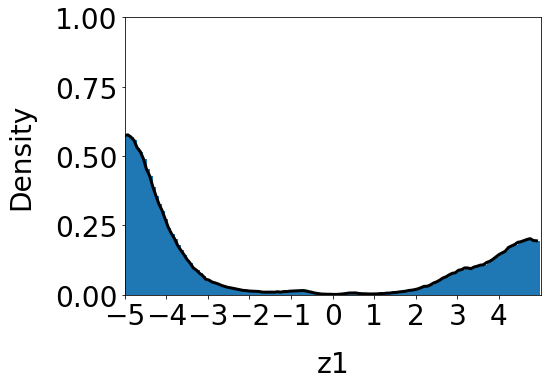

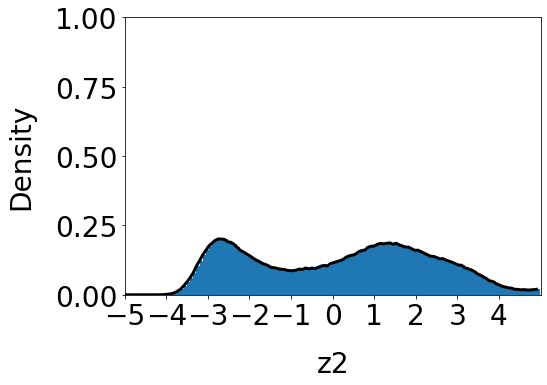

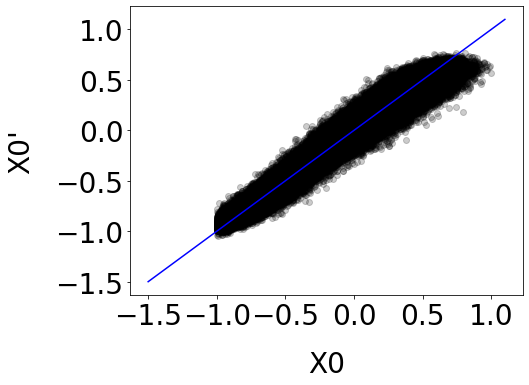

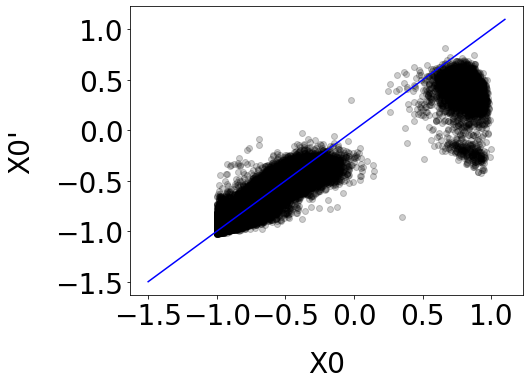

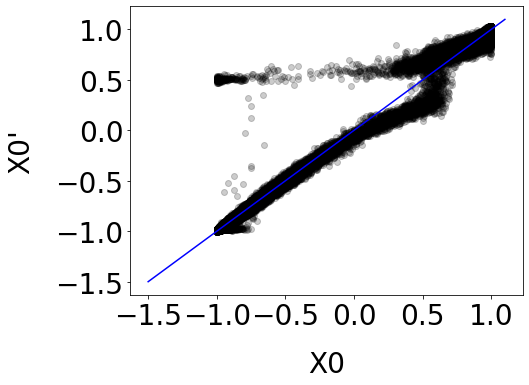

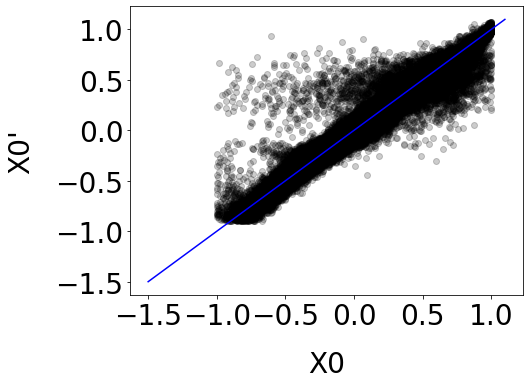

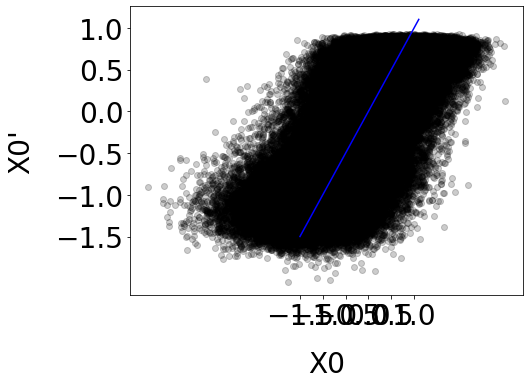

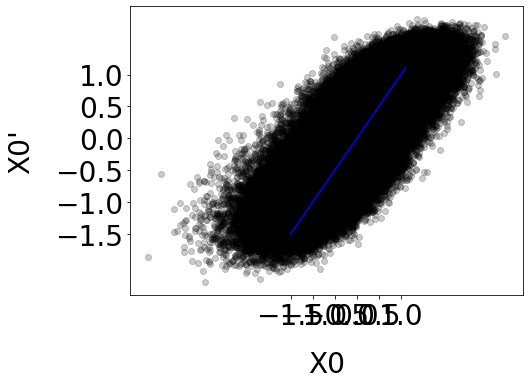

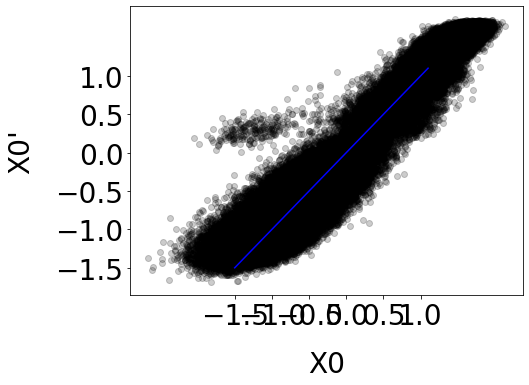

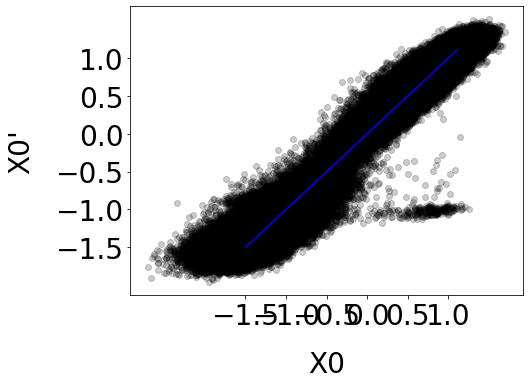

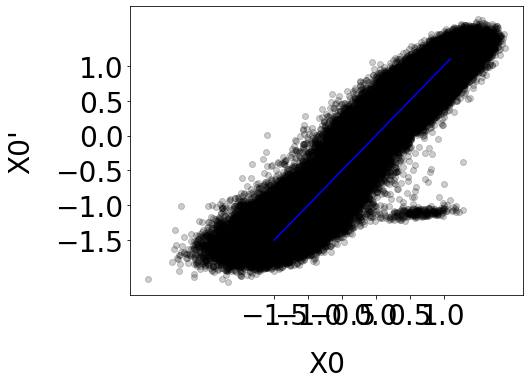

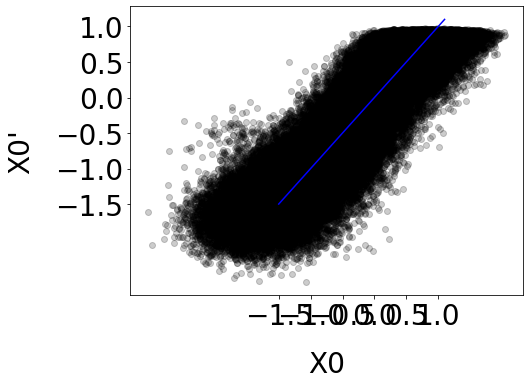

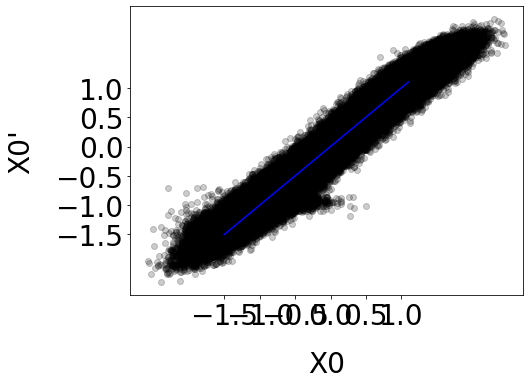

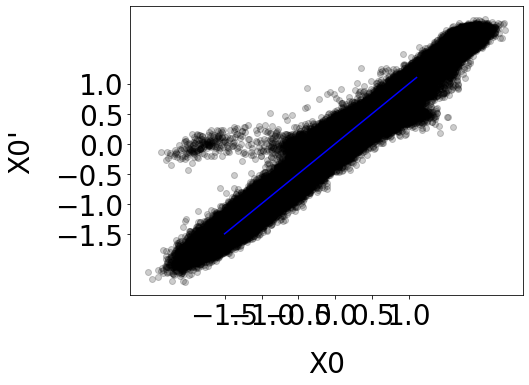

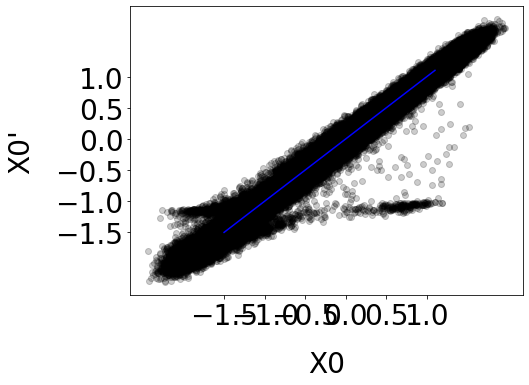

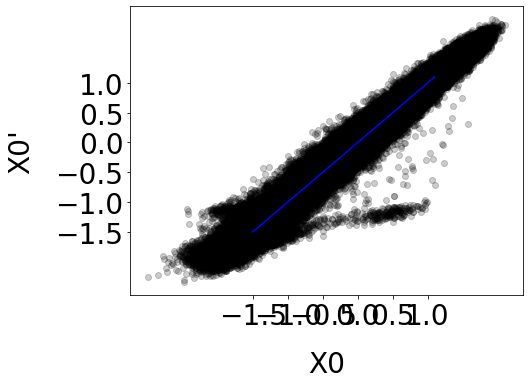

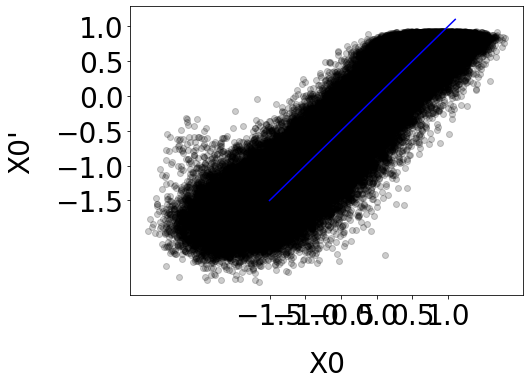

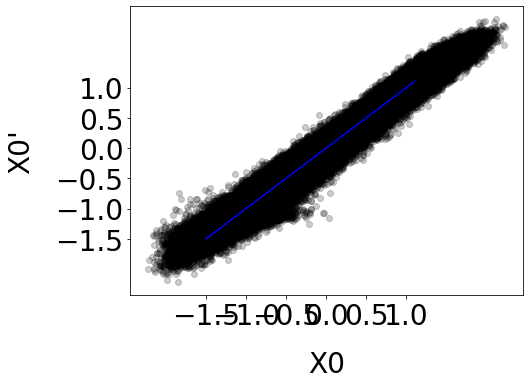

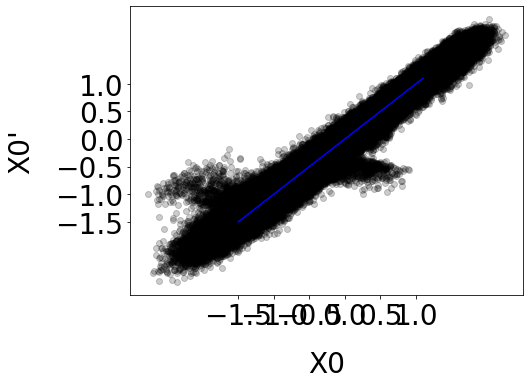

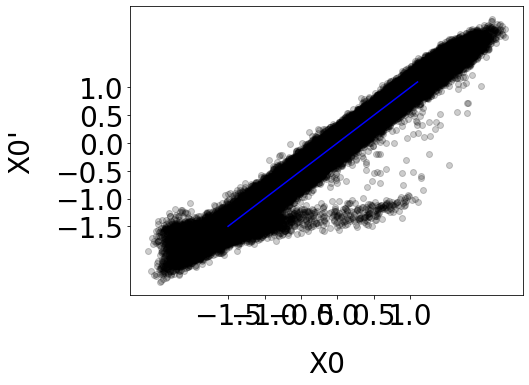

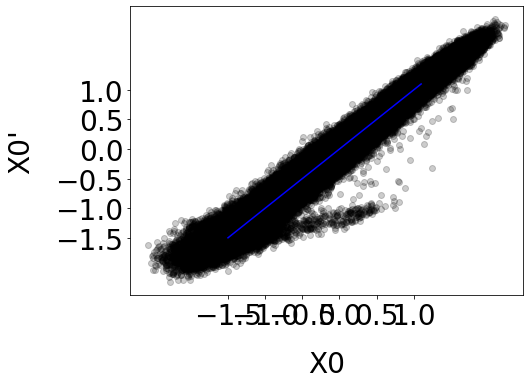

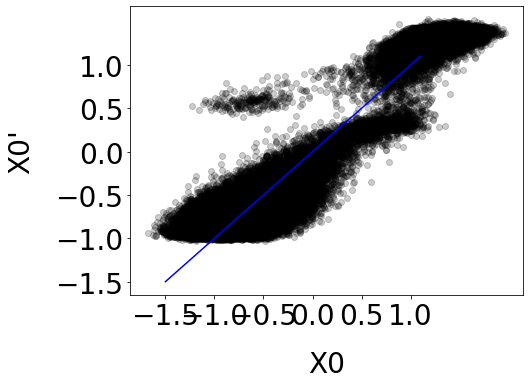

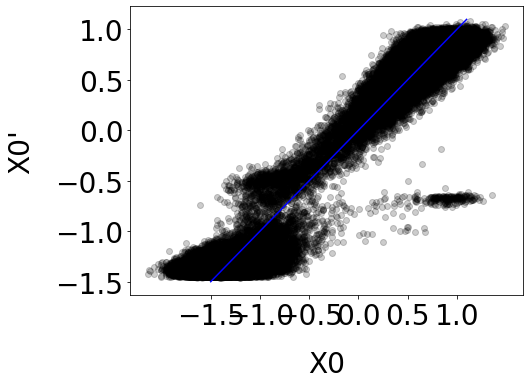

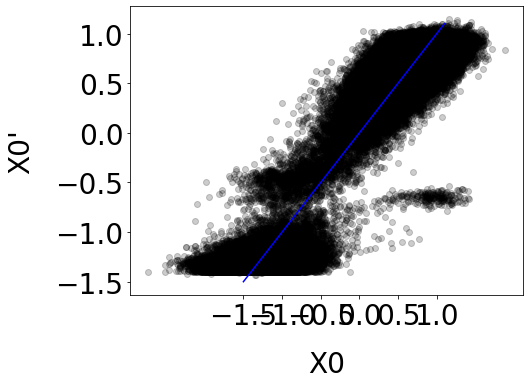

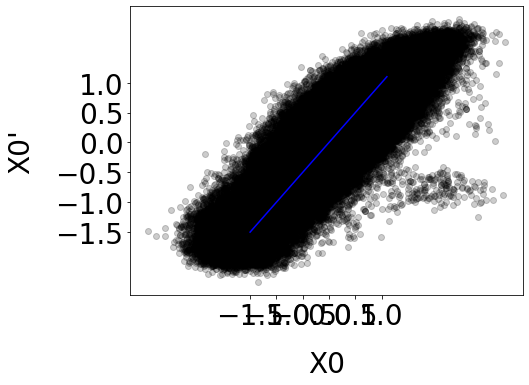

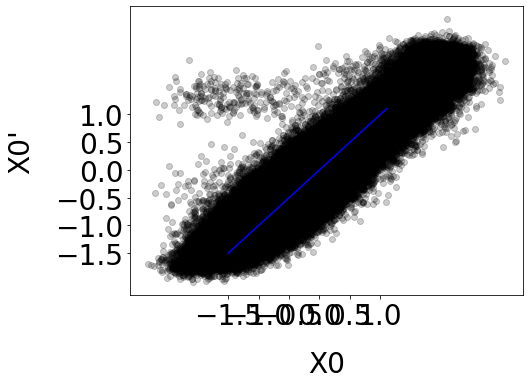

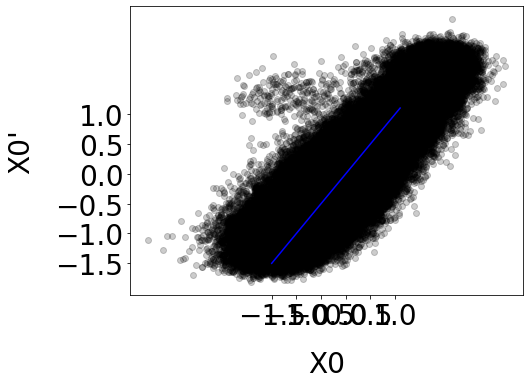

In [56]:
illustrate_and_reconstruct(model,newdata,savedir)

Okay, so this gives us pretty decent reconstruction as well as FVE, which tells us that probably the model isn't doing a great job of learning the GL13K stuff.  There are several possible reasons why that might be, including that it's more complicated, that the representation is wrong, that the hyperparameters need tweaking, or even that we just need more data.

Text(0, 0.5, 'Z1')

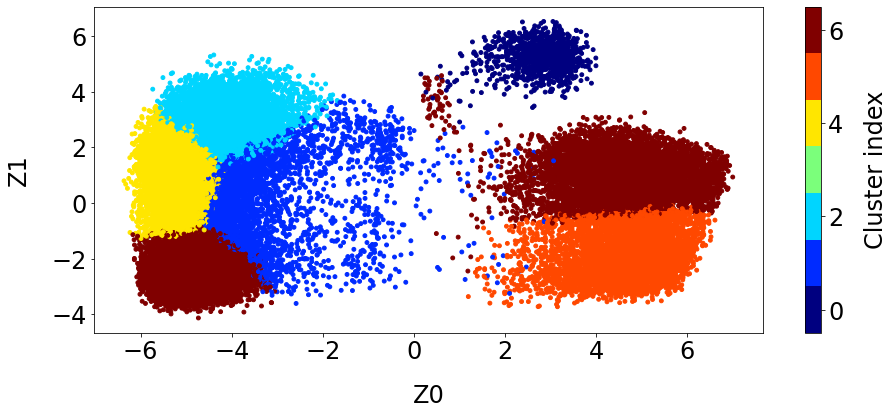

In [59]:
matplotlib.rcParams.update({'font.size': 24})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
i=0
step=20
sc = axes.scatter(z[::step,0], z[::step,1], c=y_pred[::step], alpha=1, 
                  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_alpha(1)
#cbar.set_ticks(np.arange(0, 5, 1))
cbar.set_label('Cluster index', labelpad=20)
sc.set_alpha(1)
sc.set_clim(-0.5, len(np.unique(y_pred)) - 0.5)
cbar.draw_all()

axes.set_xlabel('Z0', labelpad=20)
axes.set_ylabel('Z1', labelpad=20)
#axes.set_yticks(np.arange(-0.5,2.1,0.5))
#axes.set_xticks(np.arange(-1.5,1.5,0.5))



(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

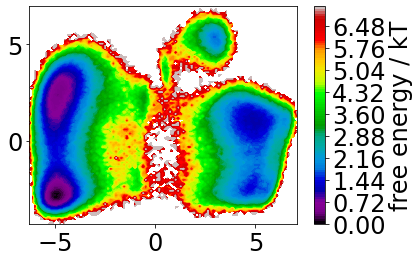

In [61]:
pyemma.plots.plot_free_energy(z[:,0],z[:,1])

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

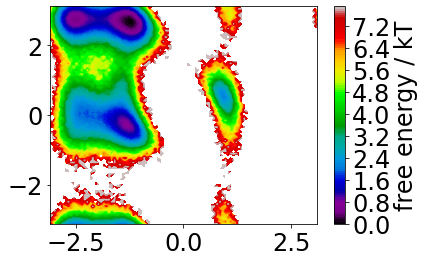

In [62]:
pyemma.plots.plot_free_energy(alldata[:,0],alldata[:,1])